In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np 
import matplotlib.pyplot as plt

import theano
import theano.tensor as tt
from theano.tensor import fft

import pymc3 as pm

# convert from arcseconds to radians
arcsec = np.pi / (180.0 * 3600) # [radians]  = 1/206265 radian/arcsec

# PyMC3 in the Fourier Plane

Let's take a gander at implementing a PyMC3 model to sample a visibility model. For simplicity's sake, we'll keep everything 1D for now. 

$$
    I(\alpha |\, \boldsymbol{\beta}) = a \exp \left [ -  \frac{(\alpha^\prime - \delta_\alpha)^2}{2 \sigma_\alpha^2} \right ]
$$

then the model visibility function (via Fourier transform pairs) is

$$
V(u |\, \boldsymbol{\beta}) = a \sqrt{2 \pi} \sigma_\alpha \exp \left [ -2 \pi^2 \sigma_\alpha^2 u^2 - 2 \pi i \delta_\alpha u \right ].
$$

Let's implement this sky plane model in numpy first

In [2]:
def sky_plane(alpha, a=1, delta_alpha=0.0, sigma_alpha=1.0*arcsec):
    '''
    alpha : coordinate in radians
    a : amplitude
    delta_alpha : offset (in radians)
    sigma_alpha : width (in radians)
    '''
    
    return a * np.exp(-(alpha - delta_alpha)**2/(2 * sigma_alpha**2))

In [3]:
def fourier_plane(u, a=1, delta_alpha=0.0, sigma_alpha=1.0*arcsec):
    '''
    u : lambda
    a : amplitude
    delta_alpha : offset (in radians)
    sigma_alpha : width (in radians)
    '''
    
    return a * np.sqrt(2 * np.pi) * sigma_alpha * \
        np.exp(-2 * np.pi**2 * sigma_alpha**2 * u**2 - 2 * np.pi * 1j * delta_alpha * u)



Derivative w.r.t. $\delta_\alpha$. According to our math, 

$$
\frac{\mathrm{d}V}{\mathrm{d}\delta_\alpha} = -2 \pi i u V
$$


In [4]:
def dV_ddelta_alpha(u, a=1, delta_alpha=0.0, sigma_alpha=1.0*arcsec):
    '''
    u : lambda
    a : amplitude
    delta_alpha : offset (in radians)
    sigma_alpha : width (in radians)
    '''
    
    return -2 * np.pi * 1j * u * fourier_plane(u, a, delta_alpha, sigma_alpha)

$$
\frac{\mathrm{d}V}{\mathrm{d}a} = \frac{V}{a}
$$

In [5]:
def dV_da(u, a=1, delta_alpha=0.0, sigma_alpha=1.0*arcsec):
    '''
    u : lambda
    a : amplitude
    delta_alpha : offset (in radians)
    sigma_alpha : width (in radians)
    '''
    
    return fourier_plane(u, a, delta_alpha, sigma_alpha) / a

$$
\frac{\mathrm{d}V}{\mathrm{d}\sigma_\alpha} = V \left ( \frac{1}{\sigma_\alpha} - 4 \pi^2 \sigma_\alpha u^2 \right)
$$

In [6]:
def dV_dsigma(u, a=1, delta_alpha=0.0, sigma_alpha=1.0*arcsec):
    '''
    u : lambda
    a : amplitude
    delta_alpha : offset (in radians)
    sigma_alpha : width (in radians)
    '''
    
    return fourier_plane(u, a, delta_alpha, sigma_alpha) * (1 / sigma_alpha - 4 * np.pi**2 * sigma_alpha * u**2)

In [7]:
def fftspace(width, N):
    '''Oftentimes it is necessary to get a symmetric coordinate array that spans ``N``
     elements from `-width` to `+width`, but makes sure that the middle point lands
     on ``0``. The indices go from ``0`` to ``N -1.``
     `linspace` returns  the end points inclusive, wheras we want to leave out the
     right endpoint, because we are sampling the function in a cyclic manner.'''

    assert N % 2 == 0, "N must be even."

    dx = width * 2.0 / N
    xx = np.empty(N, np.float64)
    for i in range(N):
        xx[i] = -width + i * dx
    
    return xx

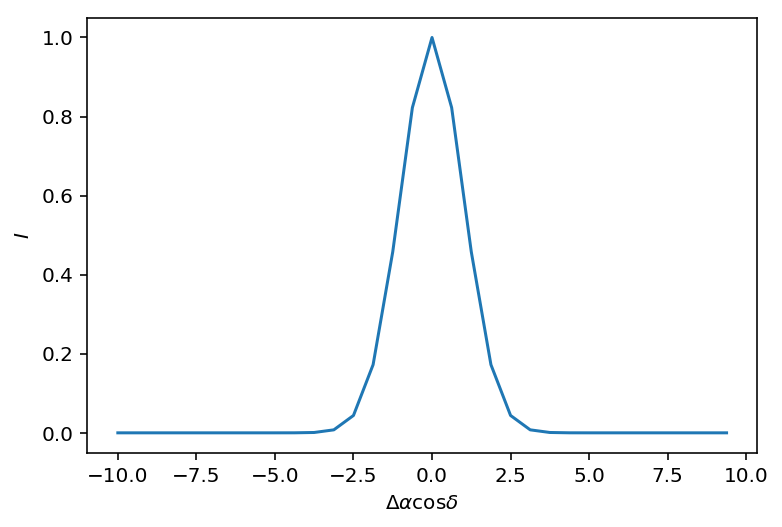

In [8]:
# Let's plot this up and see what it looks like 

N_alpha = 32 
img_radius = 10.0 * arcsec

# full span of the image
ras = fftspace(img_radius, N_alpha) # [arcsec]

# fill out an image 
ys = np.empty(N_alpha, np.float64)

for i,alpha in enumerate(ras):
    ys[i] = sky_plane(alpha)

plt.plot(ras/arcsec, ys)
plt.xlabel(r"$\Delta \alpha \cos \delta$");
plt.ylabel(r"$I$");

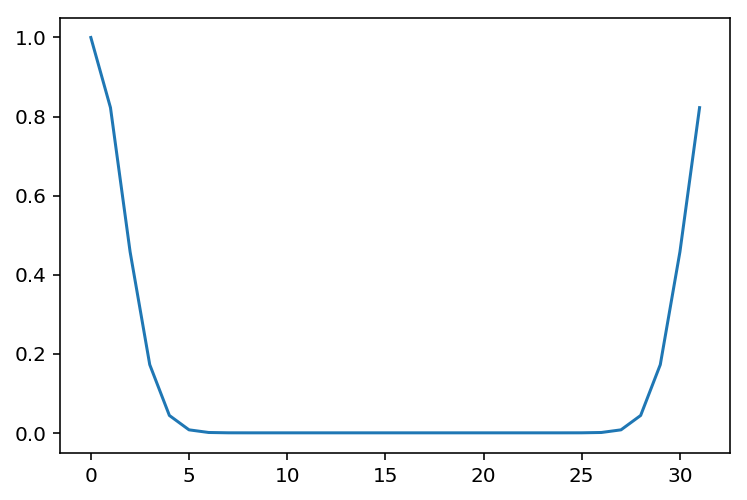

In [9]:
plt.plot(np.fft.fftshift(ys))

In [10]:
dalpha = np.abs(ras[1] - ras[0])
vis = dalpha * np.fft.ifftshift(np.fft.fft(np.fft.fftshift(ys))) #, norm="ortho")) 
freqs = np.fft.ifftshift(np.fft.fftfreq(N_alpha, 2 * img_radius/(N_alpha)))

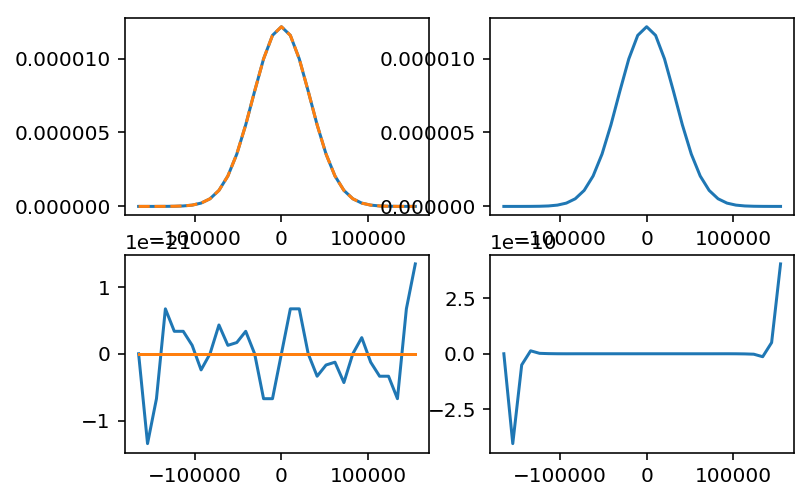

In [11]:
fp = fourier_plane(freqs)

fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0,0].plot(freqs, np.real(vis))
ax[0,0].plot(freqs, np.real(fp), ls="--")

ax[1,0].plot(freqs, np.imag(vis))
ax[1,0].plot(freqs, np.imag(fp))

ax[0,1].plot(freqs, np.abs(vis))
ax[1,1].plot(freqs, 180 / np.pi * np.angle(vis))

In [12]:
noise = 1e-6 * np.ones(N_alpha) # Jy

In [13]:
np.random.seed(42)

data_freqs = freqs
# create a dataset off of this, by adding noise to the real and imaginary parts
# i.e., we need two noise draws
data = vis + np.random.normal(loc=0, scale=noise, size=(N_alpha)) + \
    np.random.normal(loc=0, scale=noise, size=(N_alpha)) * 1.0j 

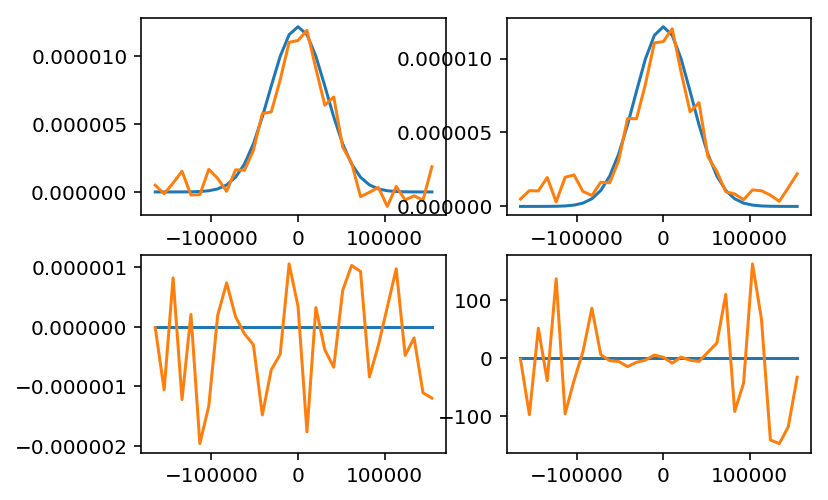

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0,0].plot(freqs, np.real(vis))
ax[0,0].plot(freqs, np.real(data))

ax[1,0].plot(freqs, np.imag(vis))
ax[1,0].plot(freqs, np.imag(data))

ax[0,1].plot(freqs, np.abs(vis))
ax[0,1].plot(freqs, np.abs(data))

ax[1,1].plot(freqs, 180 / np.pi * np.angle(vis))
ax[1,1].plot(freqs, 180 / np.pi * np.angle(data))

# Implementing this model in Theano

Now that we have a dataset, let's implement the necessary calculations in Theano. 

The most challenging part is probably figuring out how to correctly stuff and unstuff the `fft` http://deeplearning.net/software/theano/library/tensor/fft.html, especially since Theano really doesn't have complex number support. That means we're going to need to be careful about packaging the reals and imaginaries separately.

In [16]:
# Implement the sky-plane model in Theano

# a : amplitude
# delta_alpha : offset (in radians)
# sigma_alpha : width (in radians)

# create input alphas 
alpha = tt.matrix("alpha")
a = tt.scalar("a")
delta_alpha = tt.scalar("delta_alpha")
sigma_alpha = tt.scalar("sigma_alpha")

I = a * tt.exp(-(alpha - delta_alpha)**2/(2 * sigma_alpha**2))

sky_model = theano.function([alpha, a, delta_alpha, sigma_alpha], I)    

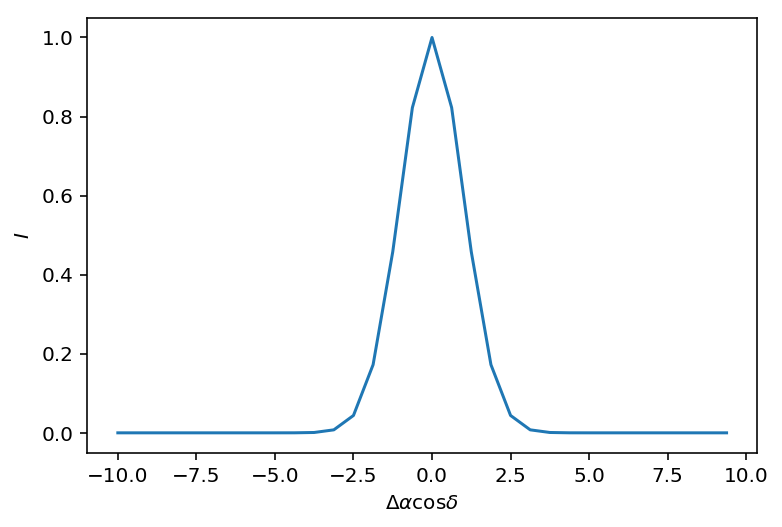

In [17]:
# Let's plot this up and see what it looks like 
N_alpha = 32 
img_radius = 10.0 * arcsec

# full span of the image
ras = fftspace(img_radius, N_alpha) # [arcsec]

# fill out an image 
ys = sky_model(ras[np.newaxis,:], 1, 0.0, 1.0*arcsec)

plt.plot(ras/arcsec, ys[0])
plt.xlabel(r"$\Delta \alpha \cos \delta$");
plt.ylabel(r"$I$");

Awesome! Let's try getting the derivative of this model using Theano. How about derivative w.r.t. $a$, $\delta_\alpha$, and $\sigma_\alpha$?

In [29]:
# gradients of arrays need to be written like this in Theano
J, updates = theano.scan(lambda i, I, delta_alpha : tt.grad(I[0,i], delta_alpha), \
                         sequences=tt.arange(I.shape[1]), non_sequences=[I, delta_alpha])

f = theano.function([alpha, a, delta_alpha, sigma_alpha], J, updates=updates)

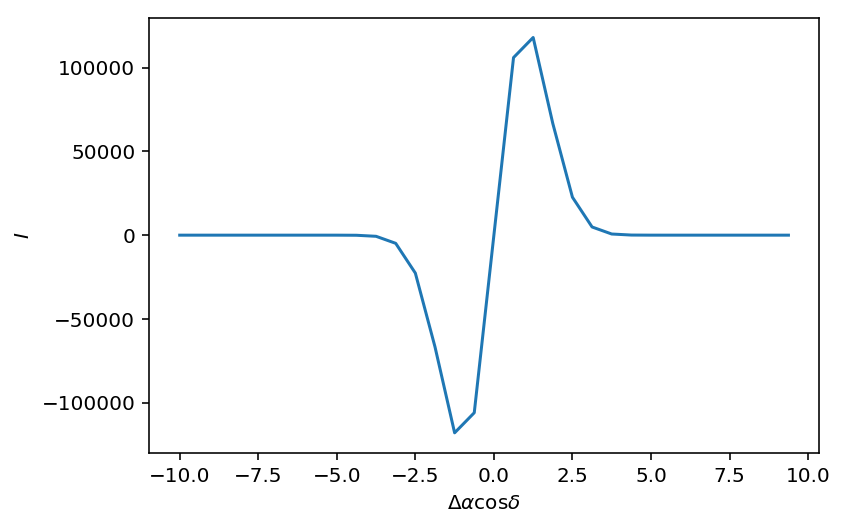

In [30]:
# fill out an image 

dys = f(ras[np.newaxis,:], 1, 0.0, 1.0*arcsec)

plt.plot(ras/arcsec, dys)
plt.xlabel(r"$\Delta \alpha \cos \delta$");
plt.ylabel(r"$I$");

In [18]:
# Implement the full sky-to-visibility model in Theano

# a : amplitude
# delta_alpha : offset (in radians)
# sigma_alpha : width (in radians)

# NOTE that these must be `fftshifted` already.
alpha = np.fft.fftshift(ras[np.newaxis,:])
dalpha = np.abs(alpha[0,1] - alpha[0,0])

a = tt.scalar("a")
delta_alpha = tt.scalar("delta_alpha")
sigma_alpha = tt.scalar("sigma_alpha")

I = a * tt.exp(-(alpha - delta_alpha)**2/(2 * sigma_alpha**2))
# since the input coordinates were already shifted, then this is too

rfft = dalpha * fft.rfft(I, norm=None)
# rshape = tt.shape(rfft)
# fshape = theano.function([alpha, a, delta_alpha, sigma_alpha], rshape)

f_vis = theano.function([a, delta_alpha, sigma_alpha], rfft)

In [25]:
# Implement the full sky-to-visibility model in Theano

# a : amplitude
# delta_alpha : offset (in radians)
# sigma_alpha : width (in radians)

# create input alphas 
# NOTE that these must be `fftshifted` already.
alpha = tt.matrix("alpha")
# calculate dalpha, the space between the grids  
dalpha = abs(alpha[0,1] - alpha[0,0])

a = tt.scalar("a")
delta_alpha = tt.scalar("delta_alpha")
sigma_alpha = tt.scalar("sigma_alpha")

I = a * tt.exp(-(alpha - delta_alpha)**2/(2 * sigma_alpha**2))
# since the input coordinates were already shifted, then this is too

rfft = dalpha * fft.rfft(I, norm=None)
# rshape = tt.shape(rfft)
# fshape = theano.function([alpha, a, delta_alpha, sigma_alpha], rshape)

f_vis = theano.function([alpha, a, delta_alpha, sigma_alpha], rfft)

In [28]:
# Implement the full sky-to-visibility model in Theano

# I think we want the grid of alphas for evaluation to be a shared variable

# a : amplitude
# delta_alpha : offset (in radians)
# sigma_alpha : width (in radians)

# create input alphas 
# NOTE that these must be `fftshifted` already.
alpha = tt.matrix("alpha")
# calculate dalpha, the space between the grids  
dalpha = abs(alpha[0,1] - alpha[0,0])

tt.set_subtensor(alpha, np.fft.fftshift(ras[np.newaxis,:]))

a = tt.scalar("a")
delta_alpha = tt.scalar("delta_alpha")
sigma_alpha = tt.scalar("sigma_alpha")

I = a * tt.exp(-(alpha - delta_alpha)**2/(2 * sigma_alpha**2))
# since the input coordinates were already shifted, then this is too

rfft = dalpha * fft.rfft(I, norm=None)
# rshape = tt.shape(rfft)
# fshape = theano.function([alpha, a, delta_alpha, sigma_alpha], rshape)

f_vis = theano.function([a, delta_alpha, sigma_alpha], rfft)

TypeError: x must be the result of a subtensor operation

In [19]:
f_vis(1.0, 0.0, 1.0)[0,:,0]

array([ 9.69627362e-05,  2.31659748e-14, -5.84767516e-15,  2.64123196e-15,
       -1.51976360e-15,  1.00157017e-15, -7.21066985e-16,  5.53015226e-16,
       -4.45125761e-16,  3.72463761e-16, -3.21930933e-16,  2.86150156e-16,
       -2.60750210e-16,  2.43043978e-16, -2.31368694e-16,  2.24722449e-16,
       -2.22566917e-16])

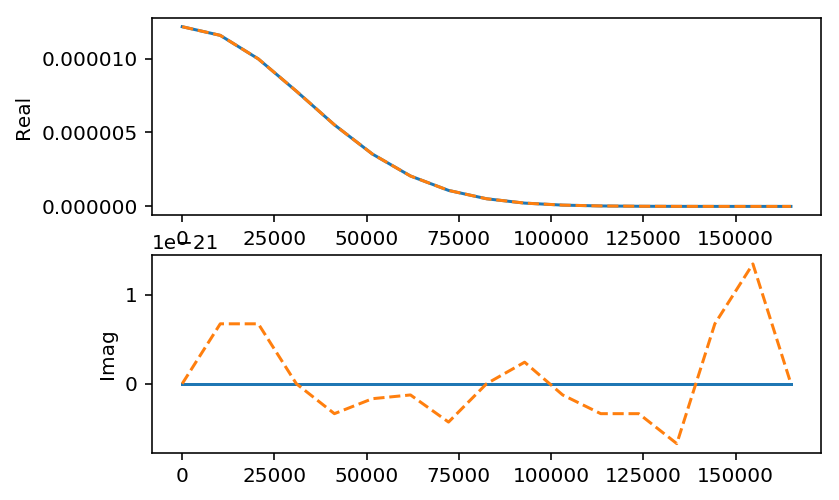

In [21]:
# let's see what these gradients look like compared to the predictions 

rfreqs = np.fft.rfftfreq(N_alpha, 2 * img_radius/(N_alpha))

fp = fourier_plane(rfreqs)

fig, ax = plt.subplots(nrows=2)

ax[0].plot(rfreqs, np.real(fp))
ax[0].plot(rfreqs, f_vis(1, 0.0, 1.0*arcsec)[0,:,0], ls="--")
ax[0].set_ylabel("Real");

ax[1].plot(rfreqs, np.imag(fp))
ax[1].plot(rfreqs, f_vis(1, 0.0, 1.0*arcsec)[0,:,1], ls="--")
ax[1].set_ylabel("Imag");

Gradients of this function. As far as I can (http://www1.spms.ntu.edu.sg/~ydchong/teaching/06_complex_derivatives.pdf) the derivative of a function that takes real-valued inputs (as ours does) is equal to the derivative of the reals plus the derivative of the imaginaries, i.e., it's ok to treat them separately. So, let's try doing that here.

In [26]:
J, updates = theano.scan(lambda i, c, delta_alpha : tt.grad(c[0,i,0], delta_alpha), \
                         sequences=tt.arange(rfft.shape[1]), non_sequences=[rfft, delta_alpha])

f_reals = theano.function([alpha, a, delta_alpha, sigma_alpha], J, updates=updates)

In [27]:
f_reals(np.fft.fftshift(ras[np.newaxis,:]), 1, 0.0, 1.0*arcsec)

array([-1.11022302e-16,  0.00000000e+00,  5.55111512e-17,  2.22044605e-16,
        0.00000000e+00,  2.77555756e-17, -1.11022302e-16, -6.93889390e-17,
        0.00000000e+00,  1.38777878e-17,  1.11022302e-16,  0.00000000e+00,
       -2.77555756e-17, -1.11022302e-16, -5.55111512e-17,  1.66533454e-16,
        1.11022302e-16])

In [37]:
J, updates = theano.scan(lambda i, c, delta_alpha : tt.grad(c[0,i,1], delta_alpha), \
                         sequences=tt.arange(rfft.shape[1]), non_sequences=[rfft, delta_alpha])

f_imags = theano.function([alpha, a, delta_alpha, sigma_alpha], J, updates=updates)

In [38]:
f_imags(np.fft.fftshift(ras[np.newaxis,:]), 1, 0.0, 1.0*arcsec)

array([ 0.00000000e+00, -7.49563160e-01, -1.29283621e+00, -1.51522420e+00,
       -1.43019291e+00, -1.14662253e+00, -7.99566161e-01, -4.91123526e-01,
       -2.67737424e-01, -1.30174180e-01, -5.66346781e-02, -2.21010021e-02,
       -7.74947151e-03, -2.44454754e-03, -6.93058202e-04, -1.69351245e-04,
        0.00000000e+00])

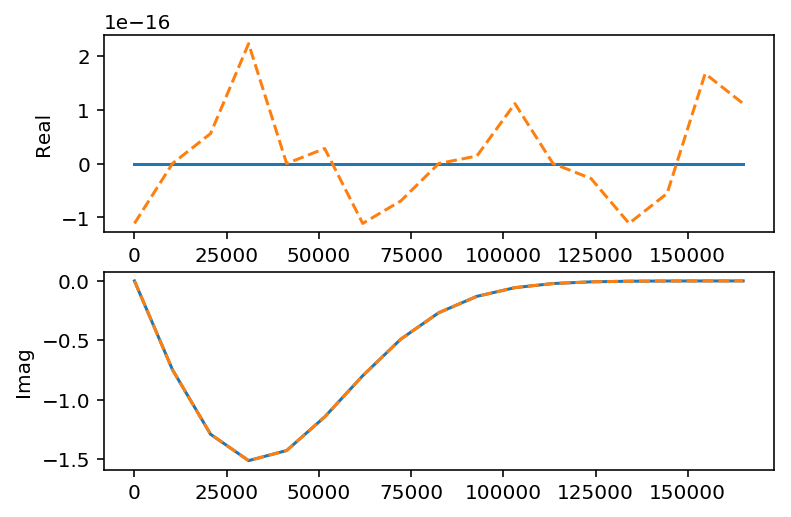

In [40]:
# let's see what these gradients look like compared to the predictions 

rfreqs = np.fft.rfftfreq(N_alpha, 2 * img_radius/(N_alpha))

dv_analytic = dV_ddelta_alpha(rfreqs)

fig, ax = plt.subplots(nrows=2)

ax[0].plot(rfreqs, np.real(dv_analytic))
ax[0].plot(rfreqs, f_reals(np.fft.fftshift(ras[np.newaxis,:]), 1, 0.0, 1.0*arcsec), ls="--")
ax[0].set_ylabel("Real");

ax[1].plot(rfreqs, np.imag(dv_analytic))
ax[1].plot(rfreqs, f_imags(np.fft.fftshift(ras[np.newaxis,:]), 1, 0.0, 1.0*arcsec), ls="--")
ax[1].set_ylabel("Imag");

In [41]:
# to check this, we'll want to combine the gradient effort to unite the real and imaginary components into 
# a single gradient, that we'll compare to the analytic gradients.

In [42]:
J, updates = theano.scan(lambda i, c, a : tt.grad(c[0,i,0], a), \
                         sequences=tt.arange(rfft.shape[1]), non_sequences=[rfft, a])

f_reals_a = theano.function([alpha, a, delta_alpha, sigma_alpha], J, updates=updates)

In [43]:
f_reals_a(np.fft.fftshift(ras[np.newaxis,:]), 1, 0.0, 1.0*arcsec)

array([1.21524768e-05, 1.15673327e-05, 9.97558805e-06, 7.79436318e-06,
       5.51771955e-06, 3.53895842e-06, 2.05649733e-06, 1.08272382e-06,
       5.16468796e-07, 2.23206756e-07, 8.73991962e-08, 3.10059077e-08,
       9.96597084e-09, 2.90243291e-09, 7.67114281e-10, 1.90825496e-10,
       7.92888178e-11])

In [44]:
J, updates = theano.scan(lambda i, c, a : tt.grad(c[0,i,1], a), \
                         sequences=tt.arange(rfft.shape[1]), non_sequences=[rfft, a])

f_imags_a = theano.function([alpha, a, delta_alpha, sigma_alpha], J, updates=updates)

In [45]:
f_imags_a(np.fft.fftshift(ras[np.newaxis,:]), 1, 0.0, 1.0*arcsec)

array([ 0.00000000e+00,  5.29395592e-22,  6.35274710e-22,  2.11758237e-22,
       -6.35274710e-22,  4.23516474e-22, -4.23516474e-22,  0.00000000e+00,
        4.23516474e-22,  0.00000000e+00,  4.23516474e-22,  4.23516474e-22,
       -4.23516474e-22,  2.11758237e-22,  8.47032947e-22,  4.23516474e-22,
        0.00000000e+00])

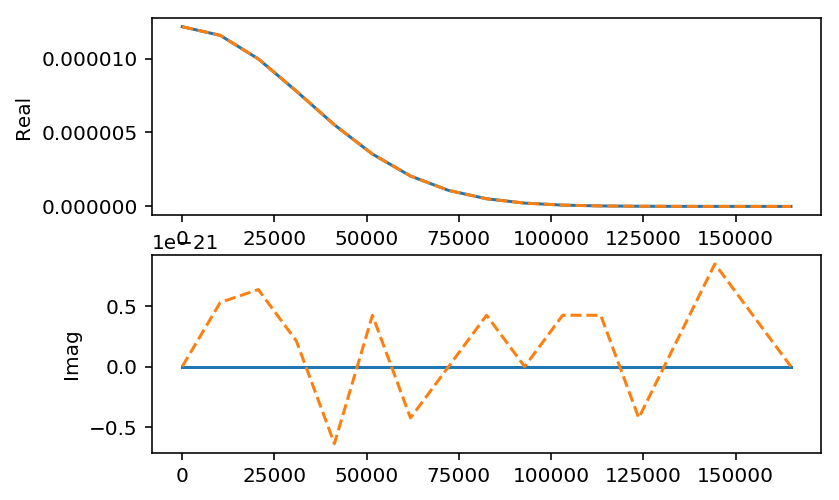

In [46]:
# let's see what these gradients look like compared to the predictions 

rfreqs = np.fft.rfftfreq(N_alpha, 2 * img_radius/(N_alpha))

dv_analytic = dV_da(rfreqs)

fig, ax = plt.subplots(nrows=2)

ax[0].plot(rfreqs, np.real(dv_analytic))
ax[0].plot(rfreqs, f_reals_a(np.fft.fftshift(ras[np.newaxis,:]), 1, 0.0, 1.0*arcsec), ls="--")
ax[0].set_ylabel("Real");

ax[1].plot(rfreqs, np.imag(dv_analytic))
ax[1].plot(rfreqs, f_imags_a(np.fft.fftshift(ras[np.newaxis,:]), 1, 0.0, 1.0*arcsec), ls="--")
ax[1].set_ylabel("Imag");

In [47]:
# to check this, we'll want to combine the gradient effort to unite the real and imaginary components into 
# a single gradient, that we'll compare to the analytic gradients.

In [48]:
J, updates = theano.scan(lambda i, c, a : tt.grad(c[0,i,0], sigma_alpha), \
                         sequences=tt.arange(rfft.shape[1]), non_sequences=[rfft, sigma_alpha])

f_reals_sigma = theano.function([alpha, a, delta_alpha, sigma_alpha], J, updates=updates)

In [49]:
f_reals_sigma(np.fft.fftshift(ras[np.newaxis,:]), 1, 0.0, 1.0*arcsec)

array([ 2.50662827e+00,  2.15045143e+00,  1.24529979e+00,  1.79637645e-01,
       -6.59122058e-01, -1.07114788e+00, -1.08296368e+00, -8.56709223e-01,
       -5.66368203e-01, -3.22019125e-01, -1.59895718e-01, -6.99802116e-02,
       -2.71596139e-02, -9.38779196e-03, -2.90621794e-03, -8.44840043e-04,
       -3.96861181e-04])

In [50]:
J, updates = theano.scan(lambda i, c, a : tt.grad(c[0,i,1], sigma_alpha), \
                         sequences=tt.arange(rfft.shape[1]), non_sequences=[rfft, sigma_alpha])

f_imags_sigma = theano.function([alpha, a, delta_alpha, sigma_alpha], J, updates=updates)

In [51]:
f_imags_sigma(np.fft.fftshift(ras[np.newaxis,:]), 1, 0.0, 1.0*arcsec)

array([ 0.00000000e+00,  2.29286447e-16,  1.85192899e-16, -7.05496759e-17,
       -2.46923866e-16, -1.41099352e-16,  0.00000000e+00,  7.05496759e-17,
        1.76374190e-16,  7.05496759e-17,  0.00000000e+00, -1.41099352e-16,
       -1.05824514e-16, -1.05824514e-16,  2.11649028e-16,  1.54327416e-16,
        0.00000000e+00])

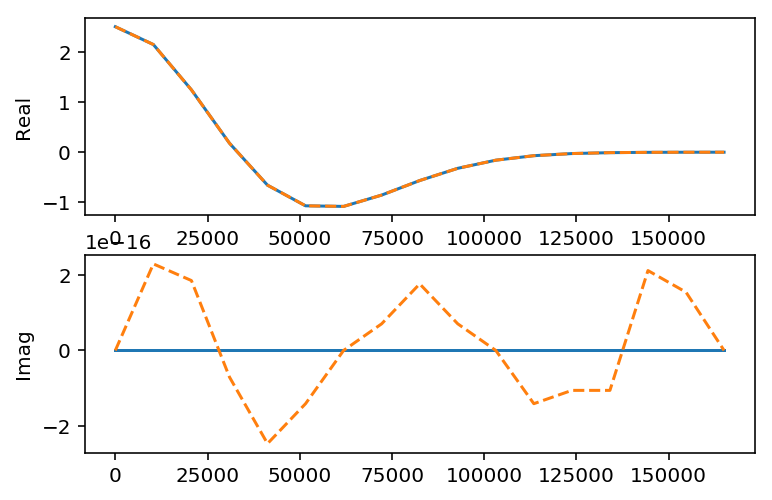

In [52]:
# let's see what these gradients look like compared to the predictions 

rfreqs = np.fft.rfftfreq(N_alpha, 2 * img_radius/(N_alpha))

dv_analytic = dV_dsigma(rfreqs)

fig, ax = plt.subplots(nrows=2)

ax[0].plot(rfreqs, np.real(dv_analytic))
ax[0].plot(rfreqs, f_reals_sigma(np.fft.fftshift(ras[np.newaxis,:]), 1, 0.0, 1.0*arcsec), ls="--")
ax[0].set_ylabel("Real");

ax[1].plot(rfreqs, np.imag(dv_analytic))
ax[1].plot(rfreqs, f_imags_sigma(np.fft.fftshift(ras[np.newaxis,:]), 1, 0.0, 1.0*arcsec), ls="--")
ax[1].set_ylabel("Imag");

In [24]:
len(data[15:])

17

In [26]:
with pm.Model() as model:

    # create input alphas 
    alpha = tt.matrix("alpha")
    # calculate dalpha, the space between the grids  
    dalpha = abs(alpha[0,1] - alpha[0,0])
    
    # stuff alpha with real values
    # NOTE that these must be `fftshifted` already.
    
    
    # Parameters
    a = pm.Uniform("a", lower=0.0, upper=10.0)
    delta_alpha = pm.Uniform("delta_alpha", lower=-1*arcsec, upper=1*arcsec)
    sigma_alpha = pm.Uniform("sigma_alpha", lower=0.5*arcsec, upper=1.5*arcsec)
    
    # sky-plane model
    # since the input coordinates were already shifted, then this is too
    I = a * tt.exp(-(alpha - delta_alpha)**2/(2 * sigma_alpha**2))

    rfft = dalpha * fft.rfft(I, norm=None)
    
    # take the output from rfft and expand it to the full-frequencies
    # Assume x has length N
    # the full-length vector will have size 2 * (N - 1)

#     c_pos = rfft[0, :-1, :]

#     # define the complex conjugate manually, by operating independently on the 
#     # real and negative components
#     c_neg_real = rfft[0,1:, 0][::-1]
#     c_neg_imag = -1.0 * rfft[0,1:, 1][::-1]

#     # assemble this back into a (N/2, 2) matrix
#     c_neg = tt.stack([c_neg_real, c_neg_imag], axis=1)

#     # combine the negative and postive chunks to make an (N, 2) output 
#     c_out = tt.concatenate([c_neg, c_pos], axis=0)
    
    # condition on the real and imaginary observations
    pm.Normal("obs_real", mu=rfft[0,:,0], sd=noise[15:], observed=np.real(data[15:]))
    pm.Normal("obs_imag", mu=rfft[0,:,1], sd=noise[15:], observed=np.imag(data[15:]))

In [27]:
with model:
    trace = pm.sample(draws=1000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


ValueError: ('You cannot drop a non-broadcastable dimension.', ((False, True), []))

In [86]:
box = np.zeros((1, N_alpha), dtype=np.float64) # shape (1, 32) because that's what Theano requires
box[:] = np.fft.fftshift(ys)

# print(fshape(box))
c_full = f_rfft(box)

In [14]:
def rfft_to_full(rfft_out):
    '''
    Take Theano rfft output (corresponding only to positive spatial frequencies) and duplicate it such that we 
    would have output corresponding to all frequencies.
    '''
    
    # 1D example 
    N = len(rfft_out)
    N_out = 2 * (N - 1)
    c_out = np.empty(N_out, dtype=np.complex128)
    
    c_out[N-1:] = rfft_out[:-1]
    c_out[:N-1] = np.conj(rfft_out[1:])[::-1] # could allocate the conj directly to array

    return c_out

In [84]:
# define the Theano operation for the FFT
# most of the complication here is unpacking the complex conjugates of the array
# It's also possible to just change around the data based upon it's u,v pairings, which might be a smarter move.

x = tt.matrix('x', dtype='float64')
rfft = fft.rfft(x, norm=None)

# take the output from rfft and expand it to the full-frequencies
# Assume x has length N
# the full-length vector will have size 2 * (N - 1)

c_pos = rfft[0, :-1, :]

# define the complex conjugate manually, by operating independently on the 
# real and negative components
c_neg_real = rfft[0,1:, 0][::-1]
c_neg_imag = -1.0 * rfft[0,1:, 1][::-1]

# assemble this back into a (N/2, 2) matrix
c_neg = tt.stack([c_neg_real, c_neg_imag], axis=1)

# combine the negative and postive chunks to make an (N, 2) output 
c_out = tt.concatenate([c_neg, c_pos], axis=0)

f_rfft = theano.function([x], c_out)